# **Importing Libraries**

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# **Downloading the Data**

In [6]:
output_dir = '.'

In [7]:
!pip install allensdk

In [8]:
from allensdk.core.cell_types_cache import CellTypesCache
import os

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path it will go into your
# current working directory
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# this saves the NWB file to 'cell_types/specimen_464212183/ephys.nwb'

#!rm cell_types/specimen_464212183/ephys.nwb
cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)

# **Filtering Data**

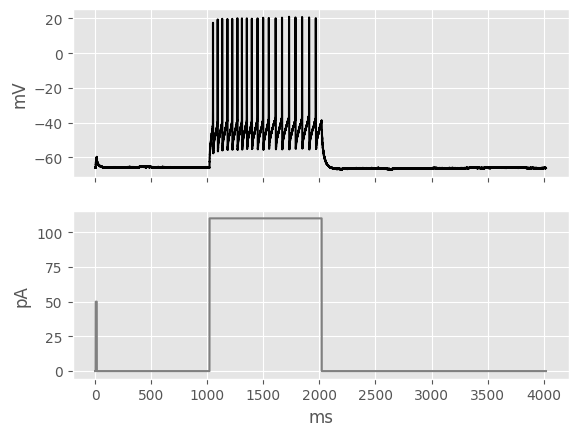

In [9]:
sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)


index_range = sweep_data["index_range"]
I = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
I *= 1e12 # to pA
v *= 1e3 # to mV


sampling_rate = sweep_data["sampling_rate"] # in Hz
#sampling rate refers to how many samples were taken per second
#200000 Hz means that 200 thousand samples were taken each second
#To find the time interval between each sample, we take the inverse of the sampling rate.
#1/200000(Hz)=5 microseconds between each sample
t = np.arange(0, len(v)) * (1.0 / sampling_rate)
#t = np.arange(0, len(v)* (1.0 / sampling_rate),(1.0 / sampling_rate))
t*=1000 # to milliseconds
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, I, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("ms")
plt.show()

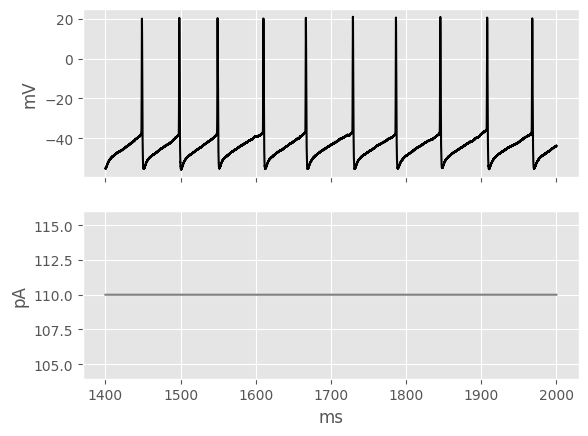

In [10]:
# Filter for time between 1 ms and 2 ms
mask = (t >=1400) & (t <= 2000)
t = t[mask]
v = v[mask]
I = I[mask]

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t,I, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("ms")
plt.show()

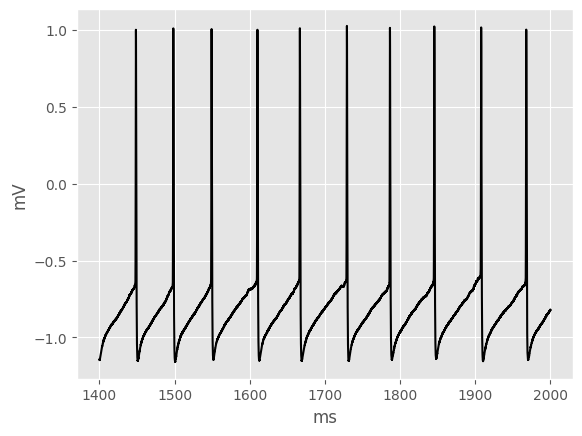

In [11]:
# Generate an index array that selects every sixth point
downsample_indices = np.arange(0, len(v), 6)

# Apply the indices to downsample the original data
v_d = v[downsample_indices]
t_d = t[downsample_indices]

# Minimum and maximum values of the original voltage data
v_min = -50
v_max = 20

# Apply the scaling transformation
v_d = 2 * (v_d - v_min) / (v_max - v_min) - 1

plt.style.use('ggplot')  # Set the style
plt.plot(t_d, v_d, color='black')  # Create a single plot
plt.ylabel("mV")  # Set the y-axis label
plt.xlabel("ms")  # Set the x-axis label
plt.show()  # Display the plot


# **First Order Simulations**

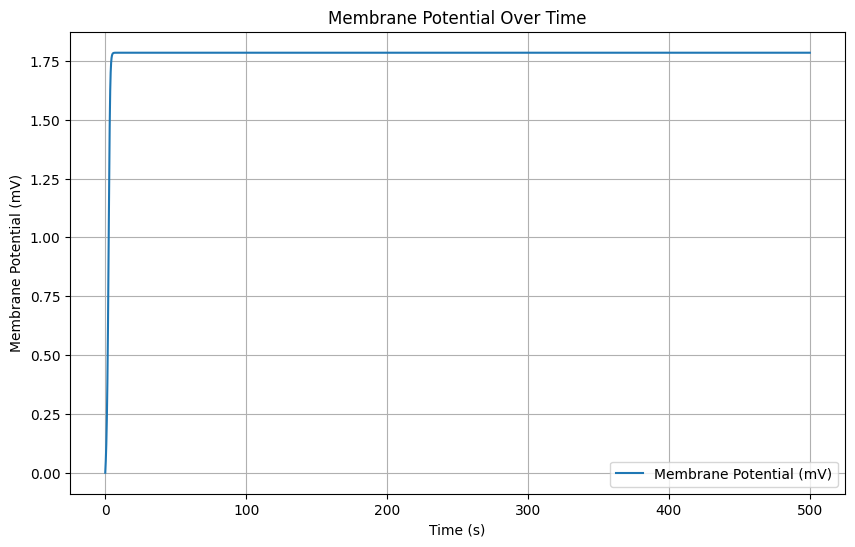

In [ ]:
class neural_model:
    def __init__(self,w,I,v_init=0):
        self.w=w
        self.I=I
        self.v=v_init
        self.history=[v_init]

    def update(self,dt):
        dvdt=(self.v-((self.v**3)/3)-self.w+self.I)*dt
        self.v+=dvdt
        self.history.append(self.v)

    def simulate(self,total_time,dt):
        iterations=int(total_time/dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history


w=0
I=0.11
total_time=500
dt=0.0001

model=neural_model(w,I)
results=model.simulate(total_time,dt)
time=np.arange(0,total_time+dt,dt)

plt.figure(figsize=(10, 6))
plt.plot(time,results,label='Membrane Potential (mV)')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential Over Time')
plt.legend()
plt.grid(True)
plt.show()

Time to reach 1.0 mV for I=0.1, w=0: 2.56 s
Threshold of 1.0 mV not reached for I=0.1, w=0.5
Threshold of 1.0 mV not reached for I=0.1, w=1.0
Time to reach 1.0 mV for I=0.5, w=0: 1.17 s
Threshold of 1.0 mV not reached for I=0.5, w=0.5
Threshold of 1.0 mV not reached for I=0.5, w=1.0
Time to reach 1.0 mV for I=1.0, w=0: 0.73 s
Time to reach 1.0 mV for I=1.0, w=0.5: 1.17 s
Threshold of 1.0 mV not reached for I=1.0, w=1.0
Time to reach 1.0 mV for I=1.5, w=0: 0.54 s
Time to reach 1.0 mV for I=1.5, w=0.5: 0.73 s
Time to reach 1.0 mV for I=1.5, w=1.0: 1.17 s


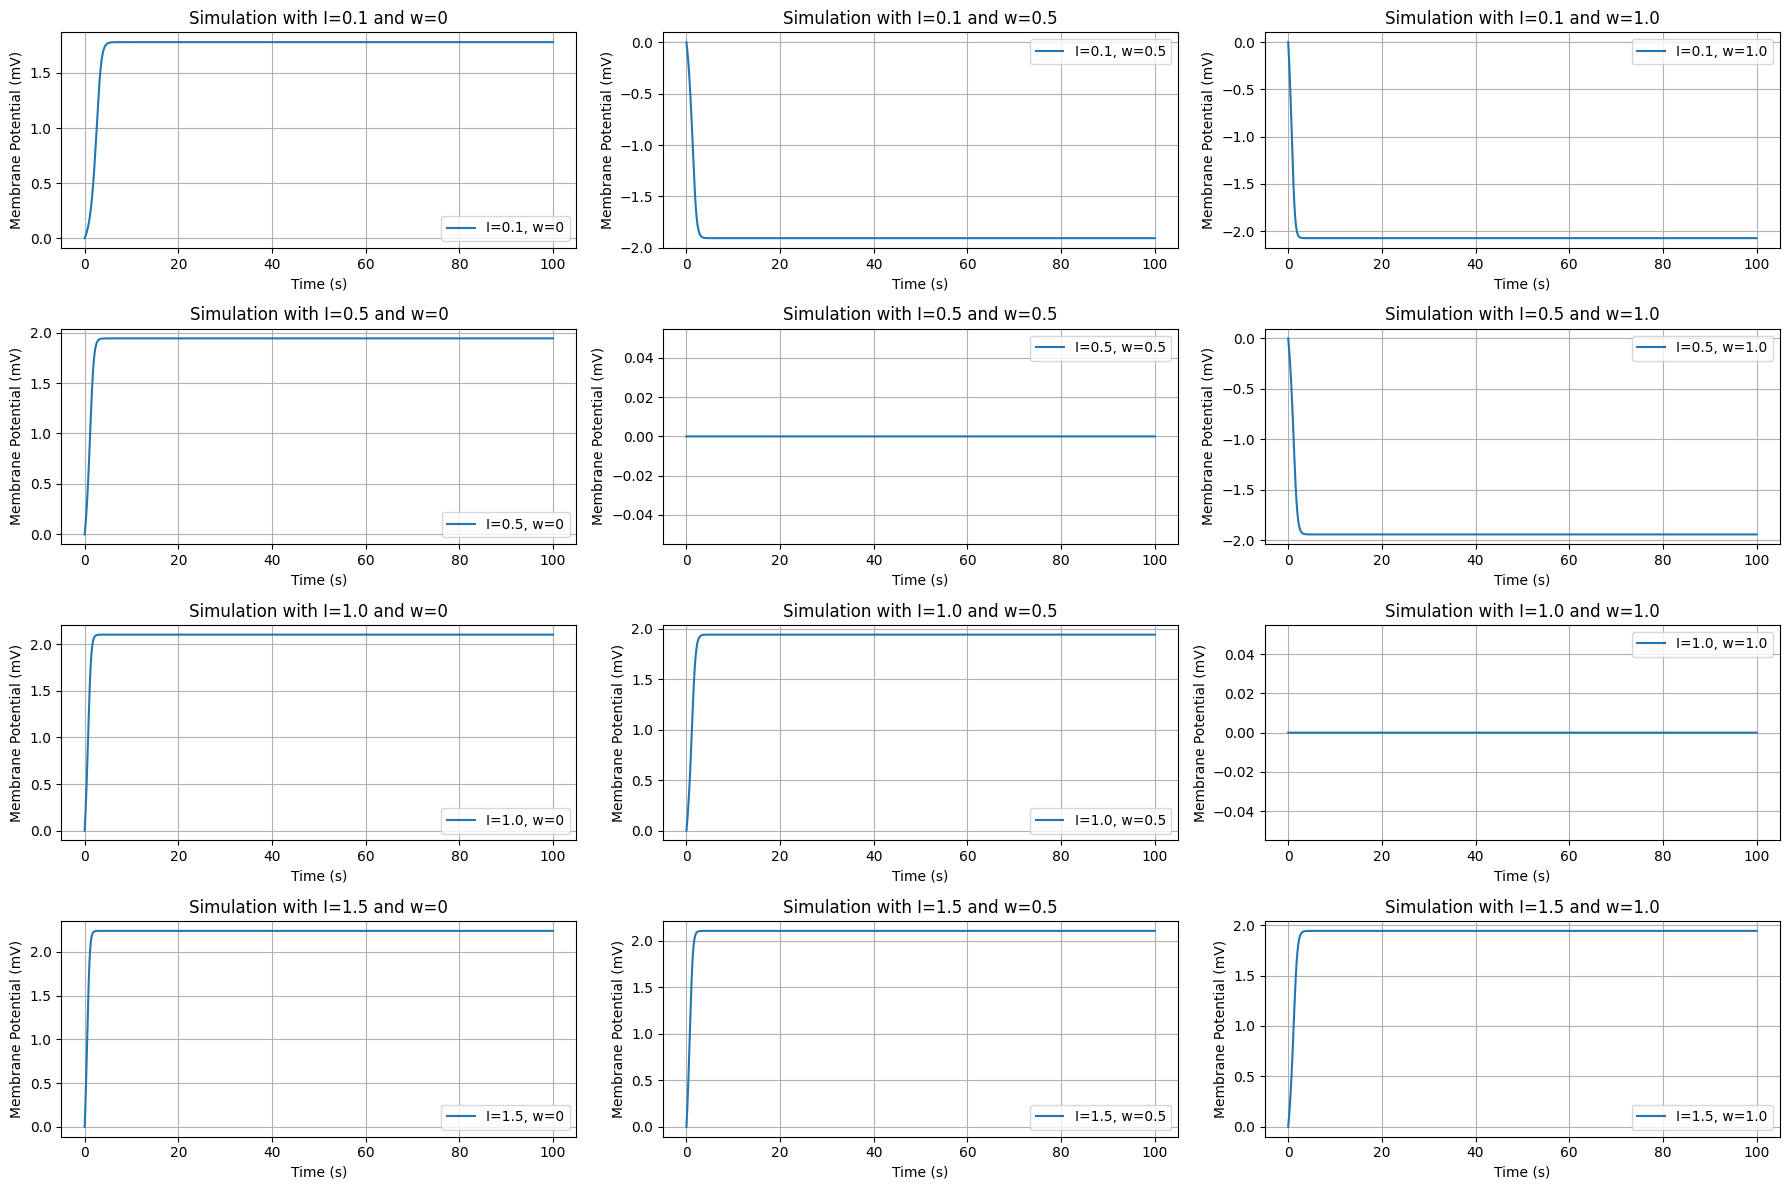

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralModel:
    def __init__(self, w, I, v_init=0):
        self.w = w
        self.I = I
        self.v = v_init
        self.history = [v_init]

    def update(self, dt):
        dvdt = (self.v - (self.v**3)/3 - self.w + self.I) * dt
        self.v += dvdt
        self.history.append(self.v)

    def simulate(self, total_time, dt):
        iterations = int(total_time/dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history

    def time_to_threshold(self, threshold, dt):
        time = 0
        for v in self.history:
            if v >= threshold:
                return time
            time += dt
        return None


total_time = 100
dt = 0.01
I_values = [0.1, 0.5, 1.0, 1.5]
w_values = [0, 0.5, 1.0]
threshold = 1.0

fig, axs = plt.subplots(len(I_values), len(w_values), figsize=(18, 12))

for i, I in enumerate(I_values):
    for j, w in enumerate(w_values):
        model = NeuralModel(w, I)
        results = model.simulate(total_time, dt)
        time = np.arange(0, total_time + dt, dt)
        axs[i, j].plot(time, results, label=f'I={I}, w={w}')
        axs[i, j].set_title(f'Simulation with I={I} and w={w}')
        axs[i, j].set_xlabel('Time (s)')
        axs[i, j].set_ylabel('Membrane Potential (mV)')
        axs[i, j].legend()
        axs[i, j].grid(True)

        time_to_reach_threshold = model.time_to_threshold(threshold, dt)
        if time_to_reach_threshold is not None:
            print(f"Time to reach {threshold} mV for I={I}, w={w}: {time_to_reach_threshold:.2f} s")
        else:
            print(f"Threshold of {threshold} mV not reached for I={I}, w={w}")

plt.tight_layout()
plt.show()


[]

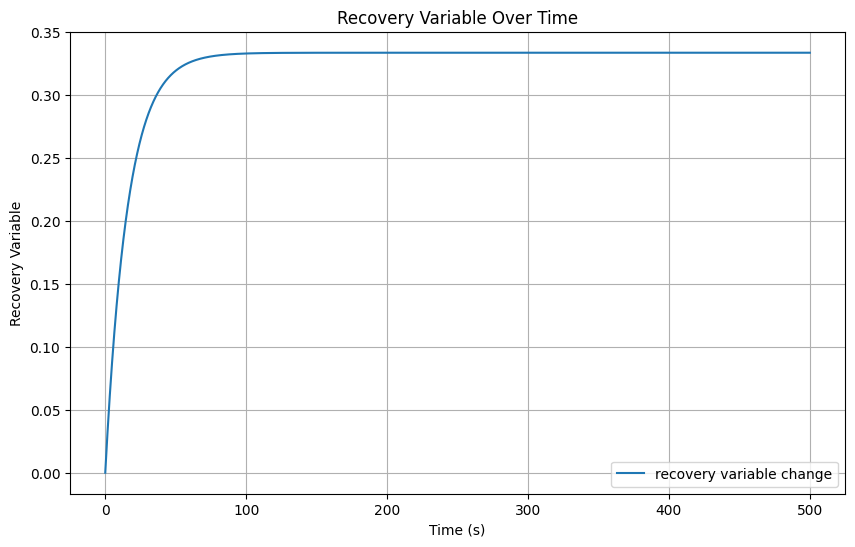

In [ ]:
class neural_model:
    def __init__(self,epsilon,v,a,b,w_init=0):
        self.v=v
        self.a=a
        self.b=b
        self.w=w_init
        self.epsilon=epsilon
        self.history=[w_init]

    def update(self,dt):
        dwdt=(self.epsilon*(self.v+self.a-(self.b*self.w)))*dt
        self.w+=dwdt
        self.history.append(self.w)

    def simulate(self,total_time,dt):
        iterations=int(total_time/dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history


v=0
a=0.3
b=0.9
epsilon=0.07
total_time=500
dt=0.0001

model=neural_model(epsilon,v,a,b)
results=model.simulate(total_time,dt)
time=np.arange(0,total_time+dt,dt)

plt.figure(figsize=(10, 6))
plt.plot(time,results,label='recovery variable change')
plt.xlabel('Time (s)')
plt.ylabel('Recovery Variable')
plt.title('Recovery Variable Over Time')
plt.legend()
plt.grid(True)
plt.plot()

Threshold of 0.5 not reached for v=0
Time to reach 0.5 for v=0.5: 13.12 s
Time to reach 0.5 for v=1.0: 6.74 s


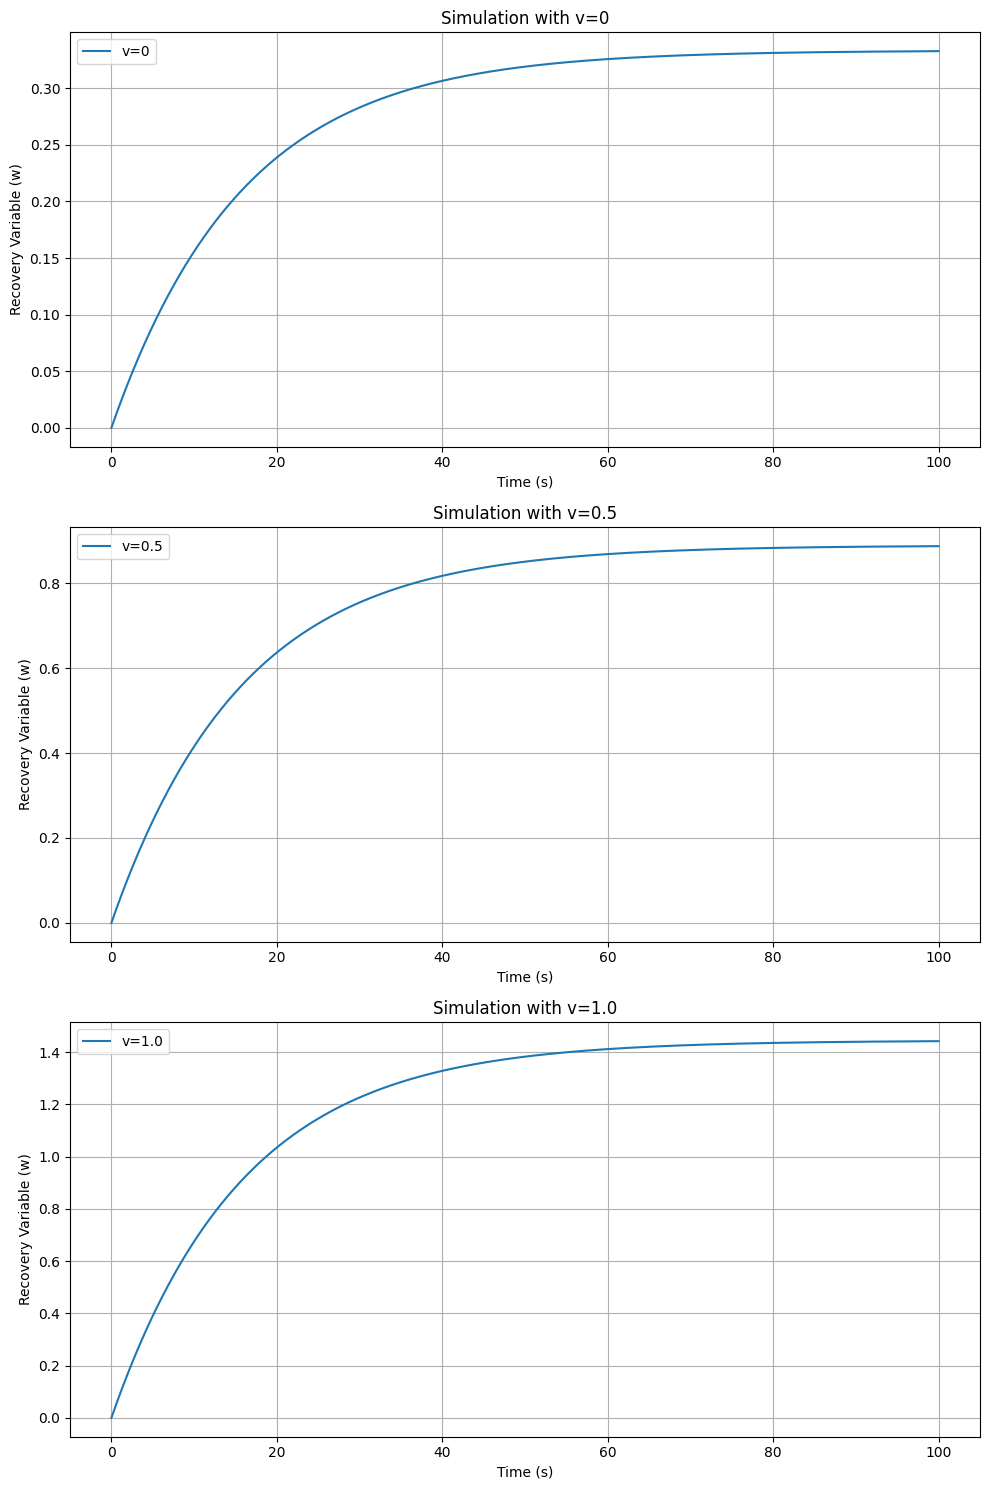

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralModel:
    def __init__(self, epsilon, v, a, b, w_init=0):
        self.v = v
        self.a = a
        self.b = b
        self.w = w_init
        self.epsilon = epsilon
        self.history = [w_init]

    def update(self, dt):
        dwdt = (self.epsilon * (self.v + self.a - self.b * self.w)) * dt
        self.w += dwdt
        self.history.append(self.w)

    def simulate(self, total_time, dt):
        iterations = int(total_time / dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history

    def time_to_threshold(self, threshold, dt):
        time = 0
        for w in self.history:
            if w >= threshold:
                return time
            time += dt
        return None
total_time = 100
dt = 0.0001
v_values = [0, 0.5, 1.0]
a = 0.3
b = 0.9
epsilon = 0.07
threshold = 0.5

fig, axs = plt.subplots(len(v_values), 1, figsize=(10, 15))

for i, v in enumerate(v_values):
    model = NeuralModel(epsilon, v, a, b)
    results = model.simulate(total_time, dt)
    time = np.arange(0, total_time + dt, dt)
    axs[i].plot(time, results, label=f'v={v}')
    axs[i].set_title(f'Simulation with v={v}')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Recovery Variable (w)')
    axs[i].legend()
    axs[i].grid(True)

    time_to_reach_threshold = model.time_to_threshold(threshold, dt)
    if time_to_reach_threshold is not None:
        print(f"Time to reach {threshold} for v={v}: {time_to_reach_threshold:.2f} s")
    else:
        print(f"Threshold of {threshold} not reached for v={v}")

plt.tight_layout()
plt.show()


# **Second Order Simulation**

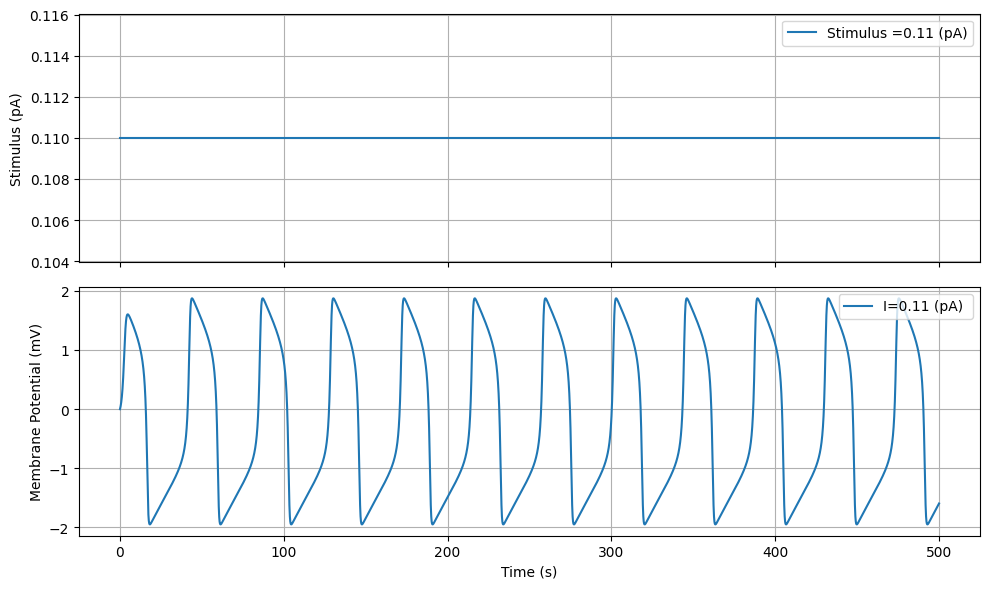

In [ ]:
class NeuralModel:
    def __init__(self,I,epsilon,a,b,w_init=0,v_init=0):
        self.v=v_init
        self.a=a
        self.b=b
        self.w=w_init
        self.I=I
        self.epsilon=epsilon
        self.history={'v':[v_init],'w':[w_init],'I':[I]}

    def update(self,dt):
        dwdt=(self.epsilon*(self.v+self.a-(self.b*self.w)))*dt
        dvdt=(self.v-((self.v**3)/3)-self.w+self.I)*dt
        self.w+=dwdt
        self.v+=dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)
        self.history['I'].append(self.I)

    def simulate(self,total_time,dt):
        iterations=int(total_time/dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history


a=0.3
b=0.9
epsilon=0.07
I_values=[0.11]
total_time=500
dt=0.0001
results=[]

for I in I_values:
    model=NeuralModel(I,epsilon,a,b)
    results.append(model.simulate(total_time,dt))
time=np.arange(0,total_time+dt,dt)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)


for index,I in enumerate(I_values):
    axs[0].plot(time, results[index]['I'], label=f'Stimulus ={I} (pA)')
    axs[0].set_ylabel('Stimulus (pA)')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

for index,I in enumerate(I_values):
    axs[1].plot(time, results[index]['v'], label=f'I={I} (pA) ', )
    axs[1].set_ylabel('Membrane Potential (mV)')
    axs[1].set_xlabel('Time (s)')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)


plt.tight_layout()
plt.show()

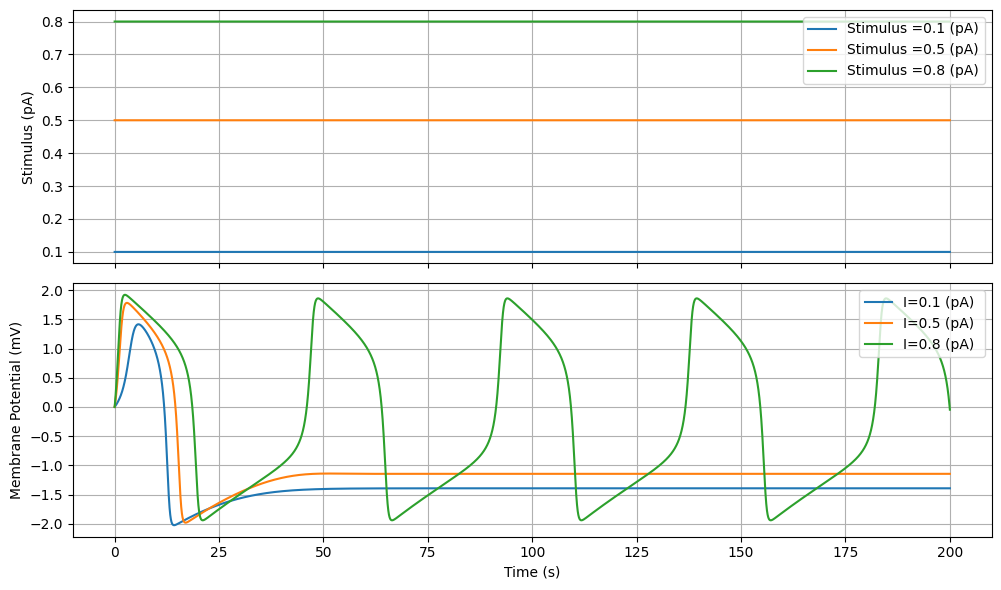

In [ ]:
class NeuralModel:
    def __init__(self,I,epsilon,a,b,w_init=0,v_init=0):
        self.v=v_init
        self.a=a
        self.b=b
        self.w=w_init
        self.I=I
        self.epsilon=epsilon
        self.history={'v':[v_init],'w':[w_init],'I':[I]}

    def update(self,dt):
        dwdt=(self.epsilon*(self.v+self.a-(self.b*self.w)))*dt
        dvdt=(self.v-((self.v**3)/3)-self.w+self.I)*dt
        self.w+=dwdt
        self.v+=dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)
        self.history['I'].append(self.I)

    def simulate(self,total_time,dt):
        iterations=int(total_time/dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history


a=1
b=1
epsilon=0.07
I_values=[0.1,0.5,0.8]
total_time=200
dt=0.0001
results=[]

for I in I_values:
    model=NeuralModel(I,epsilon,a,b)
    results.append(model.simulate(total_time,dt))
time=np.arange(0,total_time+dt,dt)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)


for index,I in enumerate(I_values):
    axs[0].plot(time, results[index]['I'], label=f'Stimulus ={I} (pA)')
    axs[0].set_ylabel('Stimulus (pA)')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

for index,I in enumerate(I_values):
    axs[1].plot(time, results[index]['v'], label=f'I={I} (pA) ', )
    axs[1].set_ylabel('Membrane Potential (mV)')
    axs[1].set_xlabel('Time (s)')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)


plt.tight_layout()
plt.show()

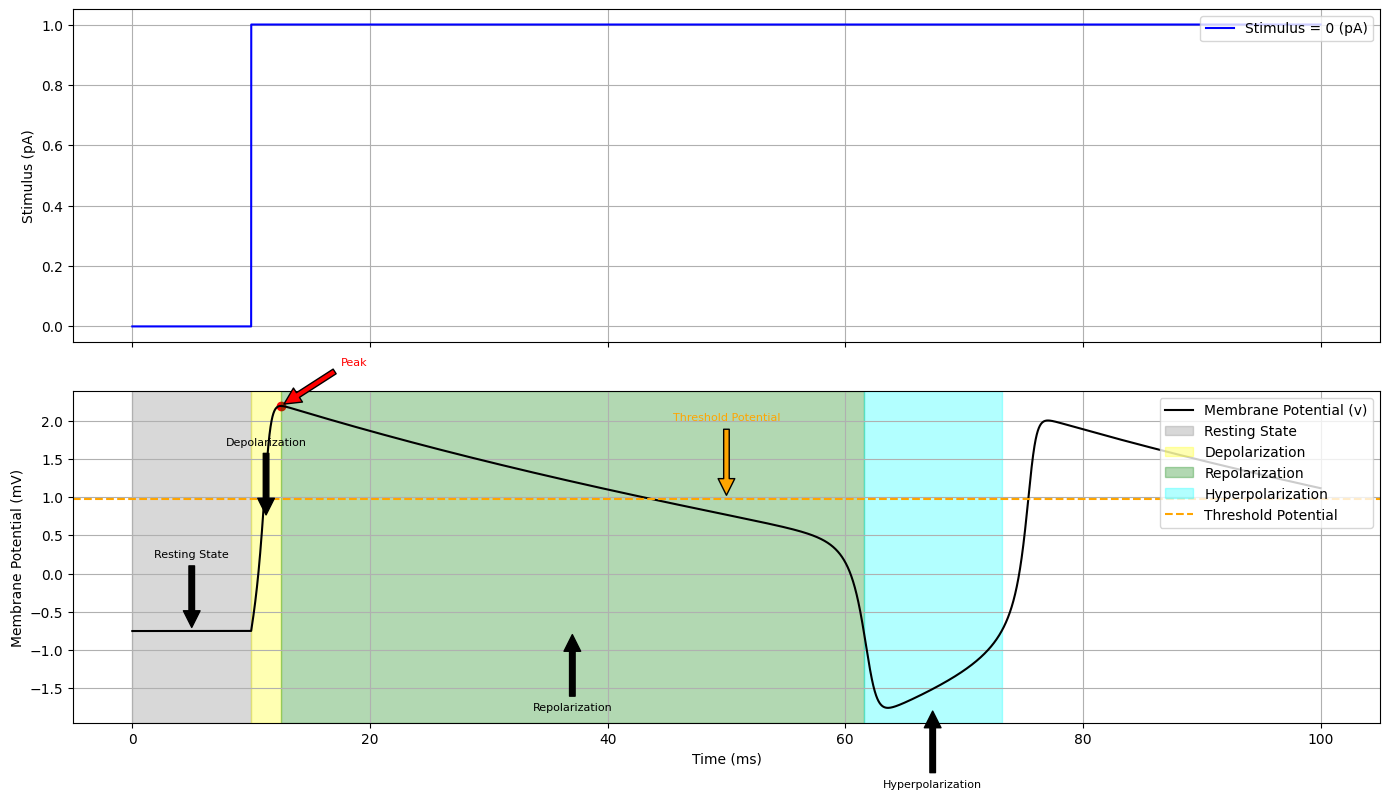

Threshold Potential: 0.97 mV


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def equilibrium_points(a, b, epsilon):
    def equations(vars):
        v, w = vars
        eq1 = v - (v**3 / 3) - w  # dv/dt = 0
        eq2 = epsilon * (v + a - b * w)  # dw/dt = 0
        return [eq1, eq2]
    v_eq, w_eq = fsolve(equations, [0, 0])
    return v_eq, w_eq

class NeuralModel:
    def __init__(self, I, epsilon, a, b, w_init=0, v_init=0):
        self.v = v_init
        self.a = a
        self.b = b
        self.w = w_init
        self.I = I
        self.epsilon = epsilon
        self.history = {'v': [v_init], 'w': [w_init], 'I': [0]}

    def update(self, dt, t):
        if t < 100000:
            stim = 0
        else:
            stim = self.I
        dwdt = (self.epsilon * (self.v + self.a - (self.b * self.w))) * dt
        dvdt = (self.v - ((self.v ** 3) / 3) - self.w + stim) * dt
        self.w += dwdt
        self.v += dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)
        self.history['I'].append(stim)

    def simulate(self, total_time, dt):
        iterations = int(total_time / dt)
        for t in range(iterations):
            self.update(dt, t)
        return self.history

# Parameters
a = 0.28728684631591367
b = 0.7595471482475482
epsilon = 0.06686628100994607
I = 1.0
total_time = 100  # 100 ms
dt = 0.0001  # 0.1 ms
results = []

v_eq, w_eq = equilibrium_points(a, b, epsilon)

model = NeuralModel(I, epsilon, a, b, w_init=w_eq, v_init=v_eq)
results = model.simulate(total_time, dt)

time = np.arange(0, total_time + dt, dt)

dvdt = np.diff(results['v']) / dt
threshold_index = np.argmax(dvdt[int(100000):]) + int(100000)  # Find the max derivative after resting state
threshold_potential = results['v'][threshold_index]

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axs[0].plot(time, results['I'], label='Stimulus = 0 (pA)', color='blue')
axs[0].set_ylabel('Stimulus (pA)')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].plot(time, results['v'], label='Membrane Potential (v)', color='black')
axs[1].set_ylabel('Membrane Potential (mV)')
axs[1].set_xlabel('Time (ms)')
axs[1].grid(True)

resting_state_time = 10
peak_potential_time = np.argmax(results['v'][int(resting_state_time/dt):]) * dt + resting_state_time
peak_potential = max(results['v'][int(resting_state_time/dt):])

# Resting phase
axs[1].axvspan(0, resting_state_time, color='gray', alpha=0.3, label='Resting State')
axs[1].annotate('Resting State', xy=(resting_state_time / 2, v_eq), xytext=(resting_state_time / 2, v_eq + 1),
                arrowprops=dict(facecolor='black', shrink=0.05), ha='center', va='center', fontsize=8, color='black')

# Depolarization phase
axs[1].axvspan(resting_state_time, peak_potential_time, color='yellow', alpha=0.3, label='Depolarization')
axs[1].annotate('Depolarization', xy=((resting_state_time + peak_potential_time) / 2, (v_eq + peak_potential) / 2),
                xytext=((resting_state_time + peak_potential_time) / 2, (v_eq + peak_potential) / 2 + 1),
                arrowprops=dict(facecolor='black', shrink=0.05), ha='center', va='center', fontsize=8, color='black')

# Peak
axs[1].scatter(peak_potential_time, peak_potential, color='red')
axs[1].annotate('Peak', xy=(peak_potential_time, peak_potential), xytext=(peak_potential_time + 5, peak_potential + 0.5),
                arrowprops=dict(facecolor='red', shrink=0.05), ha='left', va='bottom', fontsize=8, color='red')

# Repolarization phase
repolarization_end_index = np.where(np.array(results['v'][int(peak_potential_time/dt):]) < v_eq)[0]
if len(repolarization_end_index) > 0:
    repolarization_end_index = repolarization_end_index[0] + int(peak_potential_time/dt)
    repolarization_end_time = repolarization_end_index * dt
    axs[1].axvspan(peak_potential_time, repolarization_end_time, color='green', alpha=0.3, label='Repolarization')
    axs[1].annotate('Repolarization', xy=((peak_potential_time + repolarization_end_time) / 2, v_eq),
                    xytext=((peak_potential_time + repolarization_end_time) / 2, v_eq - 1),
                    arrowprops=dict(facecolor='black', shrink=0.05), ha='center', va='center', fontsize=8, color='black')

    # Hyperpolarization phase
    hyperpolarization_end_index = np.where(np.array(results['v'][repolarization_end_index:]) > v_eq)[0]
    if len(hyperpolarization_end_index) > 0:
        hyperpolarization_end_index = hyperpolarization_end_index[0] + repolarization_end_index
        hyperpolarization_end_time = hyperpolarization_end_index * dt
        axs[1].axvspan(repolarization_end_time, hyperpolarization_end_time, color='cyan', alpha=0.3, label='Hyperpolarization')
        axs[1].annotate('Hyperpolarization', xy=((repolarization_end_time + hyperpolarization_end_time) / 2, v_eq - 1),
                        xytext=((repolarization_end_time + hyperpolarization_end_time) / 2, v_eq - 2),
                        arrowprops=dict(facecolor='black', shrink=0.05), ha='center', va='center', fontsize=8, color='black')

axs[1].axhline(y=threshold_potential, color='orange', linestyle='--', label='Threshold Potential')
axs[1].annotate('Threshold Potential', xy=(time[-1] / 2, threshold_potential), xytext=(time[-1] / 2, threshold_potential + 1),
                arrowprops=dict(facecolor='orange', shrink=0.05), ha='center', va='bottom', fontsize=8, color='orange')

axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f'Threshold Potential: {threshold_potential:.2f} mV')


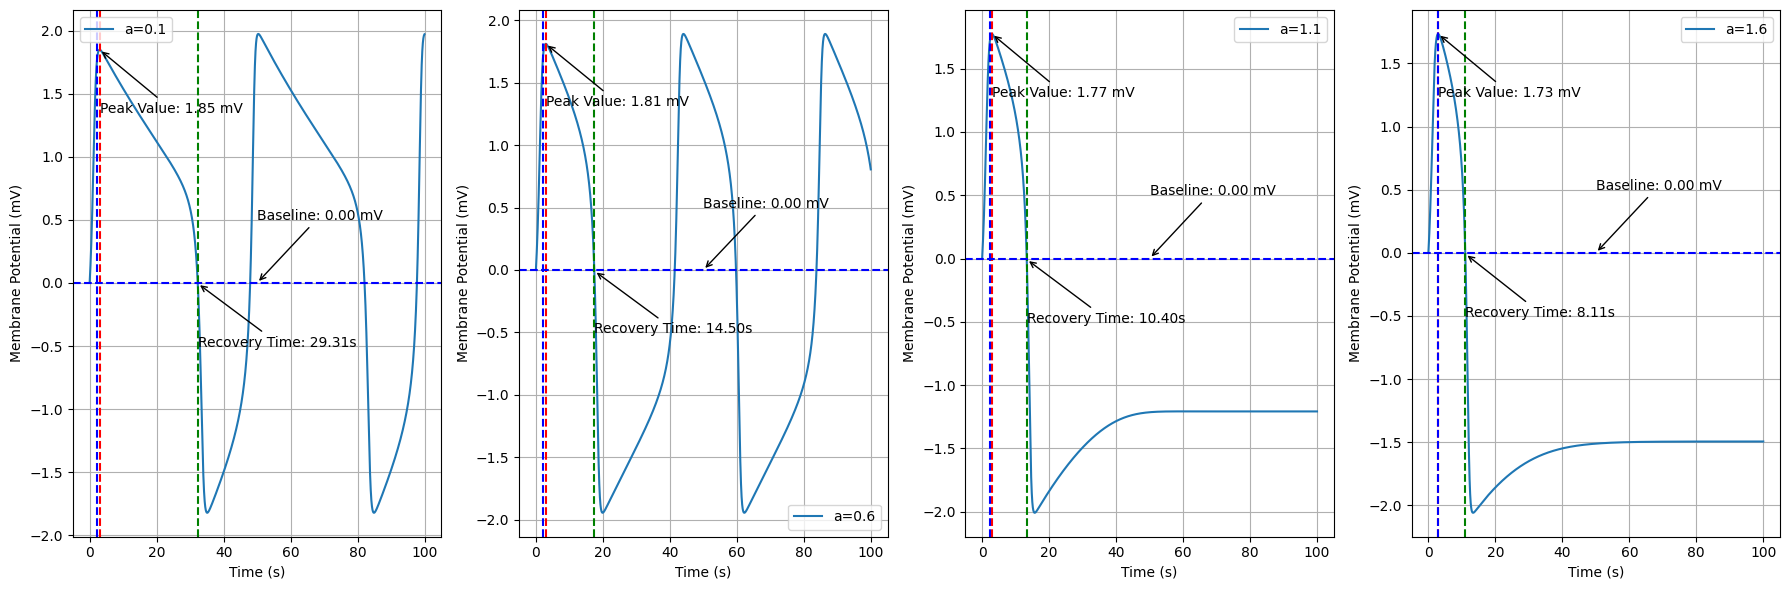

a=0.1: Frequency = 0.02 Hz, Time to Uniform Point  = 2.08 mV
a=0.6: Frequency = 0.03 Hz, Time to Uniform Point  = 2.20 mV
a=1.1: Frequency = 0.03 Hz, Time to Uniform Point  = 2.36 mV
a=1.6: Frequency = 0.01 Hz, Time to Uniform Point  = 2.73 mV


In [ ]:
def calculate_metrics(v_values, dt, uniform_point=0.5):
    peaks = [idx for idx in range(1, len(v_values) - 1) if v_values[idx] > v_values[idx - 1] and v_values[idx] > v_values[idx + 1]]
    time_to_peak = peaks[0] * dt if peaks else None
    peak_value = v_values[peaks[0]] if peaks else None

    baseline_value = v_values[0]
    recovery_idx = next((idx for idx in range(peaks[0], len(v_values)) if v_values[idx] <= baseline_value), None)
    recovery_time = (recovery_idx - peaks[0]) * dt if recovery_idx else None

    # Time to reach the uniform point
    time_to_uniform_point = next((idx * dt for idx, v in enumerate(v_values) if v >= uniform_point), None)

    num_oscillations = len(peaks)
    total_time = len(v_values) * dt
    frequency = num_oscillations / total_time if total_time > 0 else 0


    return time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value

def plot_results(results, parameter_name, parameter_values, constant_parameters, uniform_point=0.5):
    fig, axs = plt.subplots(1, len(parameter_values), figsize=(18, 6))
    for i, value in enumerate(parameter_values):
        time = np.arange(0, len(results[i]['v']) * dt, dt)
        v_values = results[i]['v']

        axs[i].plot(time, v_values, label=f'{parameter_name}={value}')
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Membrane Potential (mV)')
        axs[i].legend()
        axs[i].grid(True)

        time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value = calculate_metrics(v_values, dt, uniform_point)

        if time_to_peak is not None:
            axs[i].axvline(x=time_to_peak, color='r', linestyle='--', label='First Peak')
            #axs[i].annotate(f'Time to Peak: {time_to_peak:.2f}s', xy=(time_to_peak, v_values[int(time_to_peak/dt)]), xytext=(time_to_peak, v_values[int(time_to_peak/dt)]+0.5), arrowprops=dict(arrowstyle="->"))
            axs[i].annotate(f'Peak Value: {peak_value:.2f} mV', xy=(time_to_peak, v_values[int(time_to_peak/dt)]), xytext=(time_to_peak, v_values[int(time_to_peak/dt)]-0.5), arrowprops=dict(arrowstyle="->"))

        if recovery_time is not None:
            recovery_idx = int((time_to_peak + recovery_time) / dt)
            axs[i].axvline(x=(time_to_peak + recovery_time), color='g', linestyle='--', label='Recovery')
            axs[i].annotate(f'Recovery Time: {recovery_time:.2f}s', xy=((time_to_peak + recovery_time), v_values[recovery_idx]), xytext=((time_to_peak + recovery_time), v_values[recovery_idx]-0.5), arrowprops=dict(arrowstyle="->"))

        if time_to_uniform_point is not None:
            axs[i].axvline(x=time_to_uniform_point, color='b', linestyle='--', label='Uniform Point')
            #axs[i].annotate(f'Time to Uniform Point: {time_to_uniform_point:.2f}s', xy=(time_to_uniform_point, uniform_point), xytext=(time_to_uniform_point, uniform_point+0.5), arrowprops=dict(arrowstyle="->"))

        baseline_value = v_values[0]
        axs[i].axhline(y=baseline_value, color='b', linestyle='--', label='Baseline')
        axs[i].annotate(f'Baseline: {baseline_value:.2f} mV', xy=(time[-1]/2, baseline_value), xytext=(time[-1]/2, baseline_value+0.5), arrowprops=dict(arrowstyle="->"))

    plt.tight_layout()
    plt.show()

    for i, value in enumerate(parameter_values):
        time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value = calculate_metrics(results[i]['v'], dt, uniform_point)
        print(f'{parameter_name}={value}: Frequency = {frequency:.2f} Hz, Time to Uniform Point  = {time_to_uniform_point:.2f} mV')

total_time = 100
dt = 0.01
I = 0.5
epsilon = 0.07
b = 0.9
a_values = [0.1, 0.6, 1.1, 1.6]

results_a = []
for a in a_values:
    model = NeuralModel(I, epsilon, a, b)
    results = model.simulate(total_time, dt)
    results_a.append(results)

plot_results(results_a, 'a', a_values, {"I": I, "epsilon": epsilon, "b": b}, uniform_point=1.73)


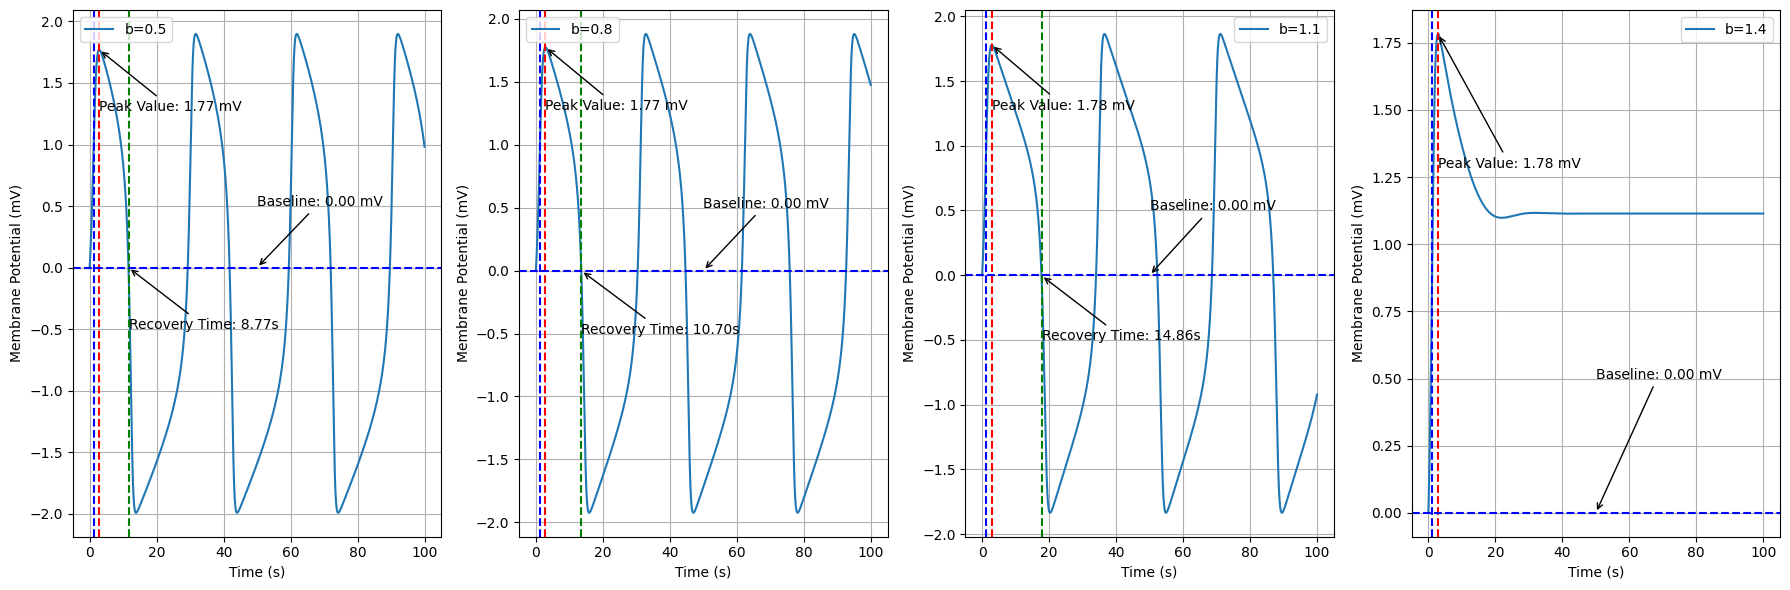

b=0.5: Frequency = 0.04 Hz, Peak Value = 1.77 mV, Time to Uniform Point = 1.22 s
b=0.8: Frequency = 0.04 Hz, Peak Value = 1.77 mV, Time to Uniform Point = 1.22 s
b=1.1: Frequency = 0.03 Hz, Peak Value = 1.78 mV, Time to Uniform Point = 1.22 s
b=1.4: Frequency = 0.05 Hz, Peak Value = 1.78 mV, Time to Uniform Point = 1.22 s


In [ ]:
def calculate_metrics(v_values, dt, uniform_point=0.5):
    peaks = [idx for idx in range(1, len(v_values) - 1) if v_values[idx] > v_values[idx - 1] and v_values[idx] > v_values[idx + 1]]
    time_to_peak = peaks[0] * dt if peaks else None
    peak_value = v_values[peaks[0]] if peaks else None

    baseline_value = v_values[0]
    recovery_idx = next((idx for idx in range(peaks[0], len(v_values)) if v_values[idx] <= baseline_value), None)
    recovery_time = (recovery_idx - peaks[0]) * dt if recovery_idx else None

    time_to_uniform_point = next((idx * dt for idx, v in enumerate(v_values) if v >= uniform_point), None)

    num_oscillations = len(peaks)
    total_time = len(v_values) * dt
    frequency = num_oscillations / total_time if total_time > 0 else 0

    return time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value

def plot_results(results, parameter_name, parameter_values, constant_parameters, uniform_point=0.5):
    fig, axs = plt.subplots(1, len(parameter_values), figsize=(18, 6))
    for i, value in enumerate(parameter_values):
        time = np.arange(0, len(results[i]['v']) * dt, dt)
        v_values = results[i]['v']

        axs[i].plot(time, v_values, label=f'{parameter_name}={value}')
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Membrane Potential (mV)')
        axs[i].legend()
        axs[i].grid(True)

        time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value = calculate_metrics(v_values, dt, uniform_point)

        if time_to_peak is not None:
            axs[i].axvline(x=time_to_peak, color='r', linestyle='--', label='First Peak')
            axs[i].annotate(f'Peak Value: {peak_value:.2f} mV', xy=(time_to_peak, v_values[int(time_to_peak/dt)]), xytext=(time_to_peak, v_values[int(time_to_peak/dt)]-0.5), arrowprops=dict(arrowstyle="->"))

        if recovery_time is not None:
            recovery_idx = int((time_to_peak + recovery_time) / dt)
            axs[i].axvline(x=(time_to_peak + recovery_time), color='g', linestyle='--', label='Recovery')
            axs[i].annotate(f'Recovery Time: {recovery_time:.2f}s', xy=((time_to_peak + recovery_time), v_values[recovery_idx]), xytext=((time_to_peak + recovery_time), v_values[recovery_idx]-0.5), arrowprops=dict(arrowstyle="->"))

        if time_to_uniform_point is not None:
            axs[i].axvline(x=time_to_uniform_point, color='b', linestyle='--', label='Uniform Point')

        baseline_value = v_values[0]
        axs[i].axhline(y=baseline_value, color='b', linestyle='--', label='Baseline')
        axs[i].annotate(f'Baseline: {baseline_value:.2f} mV', xy=(time[-1]/2, baseline_value), xytext=(time[-1]/2, baseline_value+0.5), arrowprops=dict(arrowstyle="->"))

    plt.tight_layout()
    plt.show()

    for i, value in enumerate(parameter_values):
        time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value = calculate_metrics(results[i]['v'], dt, uniform_point)
        print(f'{parameter_name}={value}: Frequency = {frequency:.2f} Hz, Peak Value = {peak_value:.2f} mV, Time to Uniform Point = {time_to_uniform_point:.2f} s')

total_time = 100
dt = 0.01
I = 0.5
epsilon = 0.1
a = 0.5
b_values = [0.5,0.8,1.1,1.4]

results_b = []
for b in b_values:
    model = NeuralModel(I, epsilon, a, b)
    results = model.simulate(total_time, dt)
    results_b.append(results)

plot_results(results_b, 'b', b_values, {"I": I, "epsilon": epsilon, "a": a}, uniform_point=1)


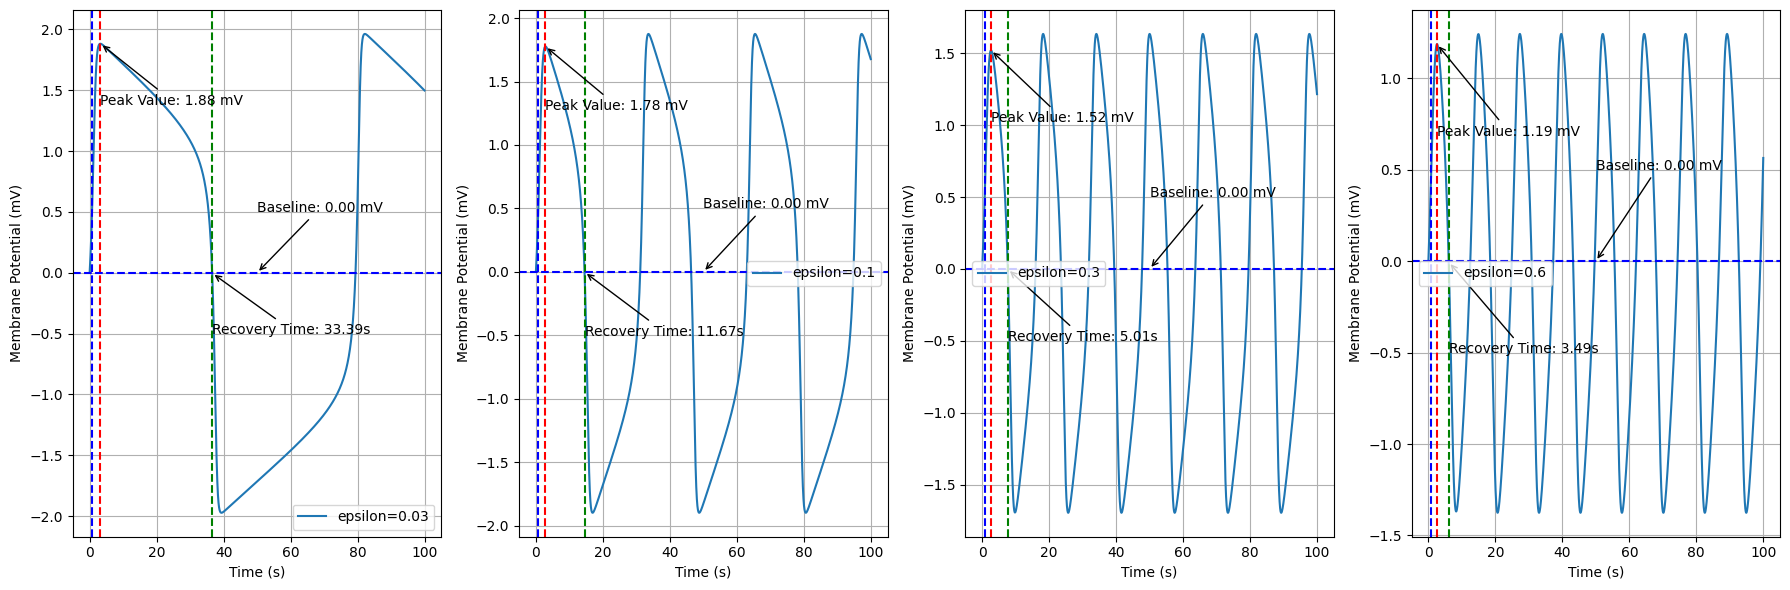

epsilon=0.03: Frequency = 0.02 Hz, Peak Value = 1.88 mV, Time to Uniform Point = 0.71 s
epsilon=0.1: Frequency = 0.04 Hz, Peak Value = 1.78 mV, Time to Uniform Point = 0.73 s
epsilon=0.3: Frequency = 0.07 Hz, Peak Value = 1.52 mV, Time to Uniform Point = 0.78 s
epsilon=0.6: Frequency = 0.08 Hz, Peak Value = 1.19 mV, Time to Uniform Point = 0.86 s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralModel:
    def __init__(self, I, epsilon, a, b, w_init=0, v_init=0):
        self.v = v_init
        self.a = a
        self.b = b
        self.w = w_init
        self.I = I
        self.epsilon = epsilon
        self.history = {'v': [v_init], 'w': [w_init]}

    def update(self, dt):
        dwdt = (self.epsilon * (self.v + self.a - (self.b * self.w))) * dt
        dvdt = (self.v - (self.v**3)/3 - self.w + self.I) * dt
        self.w += dwdt
        self.v += dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)

    def simulate(self, total_time, dt):
        iterations = int(total_time / dt)
        for _ in range(iterations):
            self.update(dt)
        return self.history

def calculate_metrics(v_values, dt, uniform_point=0.5):
    peaks = [idx for idx in range(1, len(v_values) - 1) if v_values[idx] > v_values[idx - 1] and v_values[idx] > v_values[idx + 1]]
    time_to_peak = peaks[0] * dt if peaks else None
    peak_value = v_values[peaks[0]] if peaks else None

    baseline_value = v_values[0]
    recovery_idx = next((idx for idx in range(peaks[0], len(v_values)) if v_values[idx] <= baseline_value), None)
    recovery_time = (recovery_idx - peaks [0]) * dt if recovery_idx else None


    time_to_uniform_point = next((idx * dt for idx, v in enumerate(v_values) if v >= uniform_point), None)

    num_oscillations = len(peaks)
    total_time = len(v_values) * dt
    frequency = num_oscillations / total_time if total_time > 0 else 0

    return time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value

def plot_results(results, parameter_name, parameter_values, constant_parameters, uniform_point=0.5):
    fig, axs = plt.subplots(1, len(parameter_values), figsize=(18, 6))
    for i, value in enumerate(parameter_values):
        time = np.arange(0, len(results[i]['v']) * dt, dt)
        v_values = results[i]['v']

        axs[i].plot(time, v_values, label=f'{parameter_name}={value}')
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Membrane Potential (mV)')
        axs[i].legend()
        axs[i].grid(True)

        time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value = calculate_metrics(v_values, dt, uniform_point)

        if time_to_peak is not None:
            axs[i].axvline(x=time_to_peak, color='r', linestyle='--', label='First Peak')
            axs[i].annotate(f'Peak Value: {peak_value:.2f} mV', xy=(time_to_peak, v_values[int(time_to_peak/dt)]), xytext=(time_to_peak, v_values[int(time_to_peak/dt)]-0.5), arrowprops=dict(arrowstyle="->"))

        if recovery_time is not None:
            recovery_idx = int((time_to_peak + recovery_time) / dt)
            axs[i].axvline(x=(time_to_peak + recovery_time), color='g', linestyle='--', label='Recovery')
            axs[i].annotate(f'Recovery Time: {recovery_time:.2f}s', xy=((time_to_peak + recovery_time), v_values[recovery_idx]), xytext=((time_to_peak + recovery_time), v_values[recovery_idx]-0.5), arrowprops=dict(arrowstyle="->"))

        if time_to_uniform_point is not None:
            axs[i].axvline(x=time_to_uniform_point, color='b', linestyle='--', label='Uniform Point')


        baseline_value = v_values[0]
        axs[i].axhline(y=baseline_value, color='b', linestyle='--', label='Baseline')
        axs[i].annotate(f'Baseline: {baseline_value:.2f} mV', xy=(time[-1]/2, baseline_value), xytext=(time[-1]/2, baseline_value+0.5), arrowprops=dict(arrowstyle="->"))

    plt.tight_layout()
    plt.show()

    for i, value in enumerate(parameter_values):
        time_to_peak, recovery_time, time_to_uniform_point, frequency, peak_value = calculate_metrics(results[i]['v'], dt, uniform_point)
        print(f'{parameter_name}={value}: Frequency = {frequency:.2f} Hz, Peak Value = {peak_value:.2f} mV, Time to Uniform Point = {time_to_uniform_point:.2f} s')

total_time = 100
dt = 0.01
I = 0.5
a = 0.5
b = 0.9
epsilon_values = [0.03,0.1,0.3,0.6]

results_epsilon = []
for epsilon in epsilon_values:
    model = NeuralModel(I, epsilon, a, b)
    results = model.simulate(total_time, dt)
    results_epsilon.append(results)

plot_results(results_epsilon, 'epsilon', epsilon_values, {"I": I, "a": a, "b": b}, uniform_point=0.5)


# **Optimizing Parameters**

## **Simulated Annealing**

Optimized Parameters: epsilon=0.06686628100994607, a=0.28728684631591367, b=0.7595471482475482


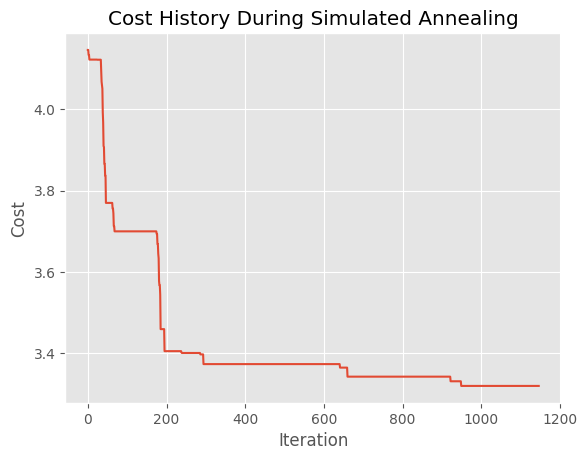

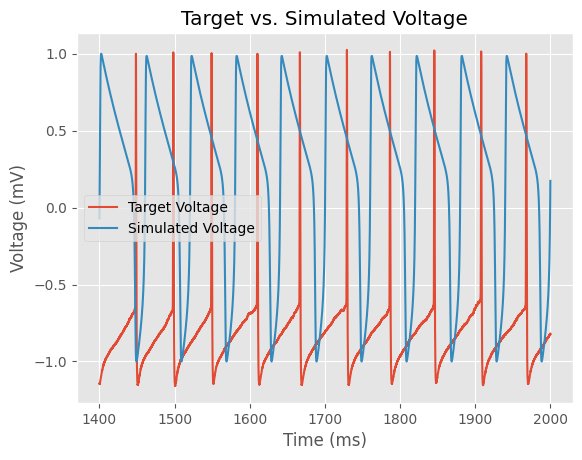

In [ ]:
class NeuralModel:
    def __init__(self,I,epsilon,a,b,w_init=0,v_init=0):
        self.v=v_init
        self.a=a
        self.b=b
        self.w=w_init
        self.I=I
        self.epsilon=epsilon
        self.history={'v':[v_init],'w':[w_init],'I':[I]}

    def update(self,dt):
        dwdt=(self.epsilon*(self.v+self.a-(self.b*self.w)))*dt
        dvdt=(self.v-((self.v**3)/3)-self.w+self.I)*dt
        self.w+=dwdt
        self.v+=dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)
        self.history['I'].append(self.I)

    def simulate(self,steps,dt):
        for _ in range(steps):
            self.update(dt)
        return self.history


def cost_function(I, epsilon, a, b, real_v, real_t, dt):
    model = NeuralModel(I, epsilon, a, b)
    total_time = real_t[-1] - real_t[0]
    steps = int(total_time / dt)

    model.simulate(steps, dt)
    time_points = np.linspace(real_t[0], real_t[-1], steps + 1)


    sim_interp = interp1d(time_points, model.history['v'], kind='linear', fill_value='extrapolate')

    simulated_at_observed = sim_interp(real_t)
    mse = np.mean((simulated_at_observed - real_v) ** 2)
    return mse

def simulated_annealing(I, real_v, real_t, dt):
    epsilon, a, b = 0.07, 0.3, 0.9
    best_epsilon, best_a, best_b = epsilon, a, b
    best_cost = cost_function(I, epsilon, a, b, real_v, real_t, dt)
    cost_history = [best_cost]
    temp = 1.0
    temp_min = 0.00001
    alpha = 0.99

    while temp > temp_min:
        epsilon_try = epsilon + np.random.uniform(-0.001, 0.001)
        a_try = a + np.random.uniform(-0.01, 0.01)
        b_try = b + np.random.uniform(-0.01, 0.01)
        cost_try = cost_function(I, epsilon_try, a_try, b_try, real_v, real_t, dt)

        if cost_try < best_cost:
            best_cost = cost_try
            best_epsilon, best_a, best_b = epsilon_try, a_try, b_try

        if cost_try < best_cost or np.random.uniform() < np.exp((best_cost - cost_try) / temp):
            epsilon, a, b = epsilon_try, a_try, b_try

        cost_history.append(best_cost)
        temp *= alpha

    return best_epsilon, best_a, best_b, cost_history


I = 1.0
dt = 0.01
real_v=v_d
real_t=t_d
best_epsilon, best_a, best_b, cost_history = simulated_annealing(I, real_v, real_t, dt)

print(f"Optimized Parameters: epsilon={best_epsilon}, a={best_a}, b={best_b}")

plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History During Simulated Annealing")
plt.show()

total_time = real_t[-1] - real_t[0]
steps = int(total_time / dt)
optimized_model = NeuralModel(I, best_epsilon, best_a, best_b)
optimized_results = optimized_model.simulate(steps, dt)


min=np.min(optimized_results['v'])
max=np.max(optimized_results['v'])
optimized_results['v'] = 2 * (optimized_results['v'] - min) / (max - min) - 1

time= np.linspace(real_t[0], real_t[-1], steps + 1)
plt.plot(real_t, real_v, label="Target Voltage")
plt.plot(time, optimized_results['v'], label="Simulated Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.title("Target vs. Simulated Voltage")
plt.show()

## **Gradient Descent**

Iteration 0: Cost = 4.1134239887482895
Iteration 100: Cost = 3.552618370731217
Iteration 200: Cost = 2.3588126652926027
Iteration 300: Cost = 0.2672936694684586
Iteration 400: Cost = 0.1967487187963043
Iteration 500: Cost = 0.16231231286405975
Iteration 600: Cost = 0.15882646582190565
Iteration 700: Cost = 0.1575011963275827
Iteration 800: Cost = 0.15631050687688794
Iteration 900: Cost = 0.1552329602054841
Optimized Parameters: epsilon=0.2787830851593697, a=0.9923437147587919, b=-0.11163986385988123


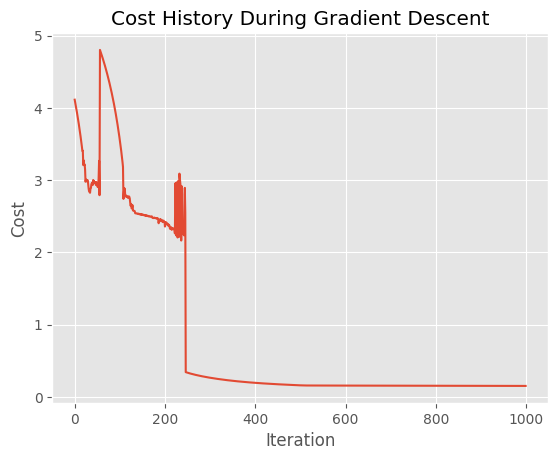

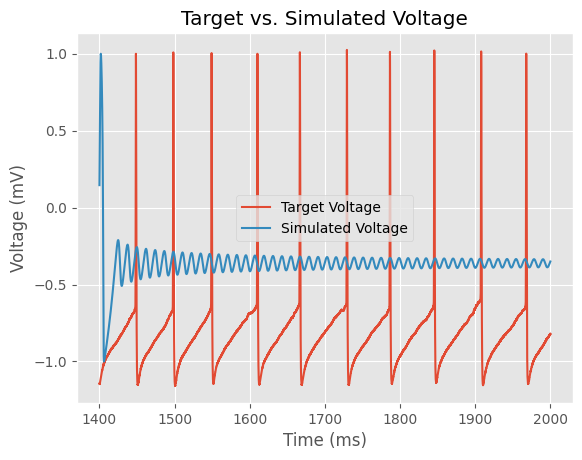

In [ ]:
class NeuralModel:
    def __init__(self, I, epsilon, a, b, w_init=0, v_init=0):
        self.v = v_init
        self.a = a
        self.b = b
        self.w = w_init
        self.I = I
        self.epsilon = epsilon
        self.history = {'v': [v_init], 'w': [w_init], 'I': [I]}

    def update(self, dt):
        dwdt = (self.epsilon * (self.v + self.a - (self.b * self.w))) * dt
        dvdt = (self.v - ((self.v**3) / 3) - self.w + self.I) * dt
        self.w += dwdt
        self.v += dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)
        self.history['I'].append(self.I)

    def simulate(self, steps, dt):
        for _ in range(steps):
            self.update(dt)
        return self.history

def cost_function(I, epsilon, a, b, real_v, real_t, dt):
    model = NeuralModel(I, epsilon, a, b)
    total_time = real_t[-1] - real_t[0]
    steps = int(total_time / dt)

    model.simulate(steps, dt)
    time_points = np.linspace(real_t[0], real_t[-1], steps + 1)

    sim_interp = interp1d(time_points, model.history['v'], kind='linear', fill_value='extrapolate')

    simulated_at_observed = sim_interp(real_t)
    mse = np.mean((simulated_at_observed - real_v) ** 2)
    return mse

def numerical_gradient(params, epsilon, I, real_v, real_t, dt):
    grad = np.zeros(len(params))
    for i in range(len(params)):
        params_forward = np.array(params)
        params_forward[i] += epsilon  # Increment the i-th parameter by epsilon
        cost_forward = cost_function(I, params_forward[0], params_forward[1], params_forward[2], real_v, real_t, dt)
        cost_current = cost_function(I, params[0], params[1], params[2], real_v, real_t, dt)
        grad[i] = (cost_forward - cost_current) / epsilon
    return grad

def gradient_descent(I, real_v, real_t, dt, initial_params=[0.07, 0.3, 0.9], learning_rate=0.001, epsilon=1e-8, max_iterations=1000):
    params = np.array(initial_params, dtype=np.float64)
    cost_history = []

    for iteration in range(max_iterations):
        grad = numerical_gradient(params, epsilon, I, real_v, real_t, dt)
        params -= learning_rate * grad
        cost = cost_function(I, params[0], params[1], params[2], real_v, real_t, dt)
        cost_history.append(cost)

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Cost = {cost}")

    return params[0], params[1], params[2], cost_history


I = 1.0
dt = 0.01
real_v = v_d
real_t = t_d

best_epsilon, best_a, best_b, history = gradient_descent(I, real_v, real_t, dt)

print(f"Optimized Parameters: epsilon={best_epsilon}, a={best_a}, b={best_b}")

plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History During Gradient Descent")
plt.show()

total_time = real_t[-1] - real_t[0]
steps = int(total_time / dt)
optimized_model = NeuralModel(I, best_epsilon, best_a, best_b)
optimized_results = optimized_model.simulate(steps, dt)

min=np.min(optimized_results['v'])
max=np.max(optimized_results['v'])
optimized_results['v'] = 2 * (optimized_results['v'] - min) / (max - min) - 1

time_points = np.linspace(real_t[0], real_t[-1], steps + 1)
plt.plot(real_t, real_v, label="Target Voltage")
plt.plot(time_points, optimized_results['v'], label="Simulated Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.title("Target vs. Simulated Voltage")
plt.show()


## **Genetic Algorithm**

Optimized Parameters: epsilon=1.0, a=0.9671012706619267, b=0.6748364906166683


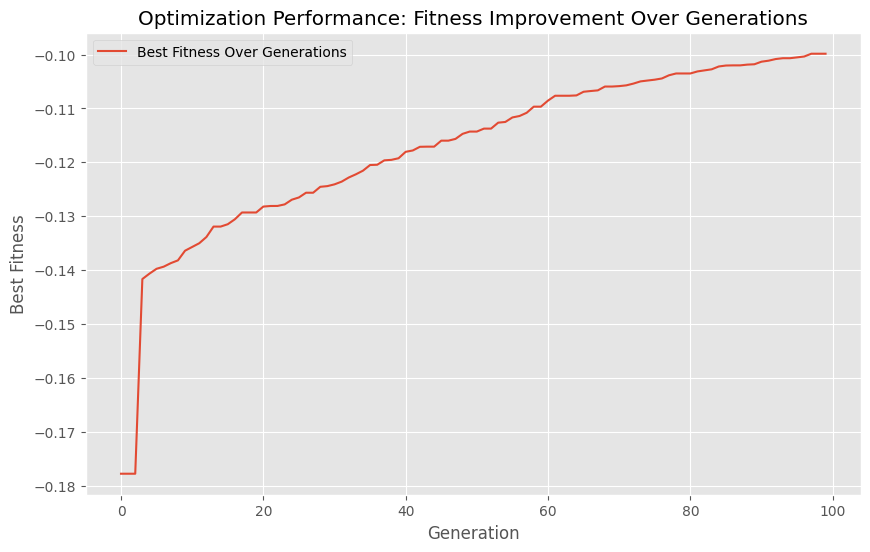

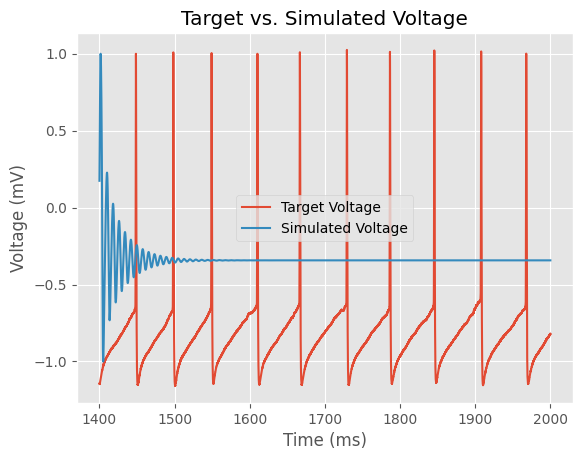

In [ ]:
class NeuralModel:
    def __init__(self, I, epsilon, a, b, w_init=0, v_init=0):
        self.v = v_init
        self.a = a
        self.b = b
        self.w = w_init
        self.I = I
        self.epsilon = epsilon
        self.history = {'v': [v_init], 'w': [w_init], 'I': [I]}

    def update(self, dt):
        dwdt = (self.epsilon * (self.v + self.a - (self.b * self.w))) * dt
        dvdt = (self.v - ((self.v**3) / 3) - self.w + self.I) * dt
        self.w += dwdt
        self.v += dvdt
        self.history['v'].append(self.v)
        self.history['w'].append(self.w)
        self.history['I'].append(self.I)

    def simulate(self, steps, dt):
        for _ in range(steps):
            self.update(dt)
        return self.history

def cost_function(I, epsilon, a, b, real_v, real_t, dt):
    model = NeuralModel(I, epsilon, a, b)
    total_time = real_t[-1] - real_t[0]
    steps = int(total_time / dt)

    model.simulate(steps, dt)
    time_points = np.linspace(real_t[0], real_t[-1], steps + 1)

    sim_interp = interp1d(time_points, model.history['v'], kind='linear', fill_value='extrapolate')

    simulated_at_observed = sim_interp(real_t)
    mse = np.mean((simulated_at_observed - real_v) ** 2)
    return mse

def fitness_function(epsilon, a, b, I, real_v, real_t, dt):
    mse = cost_function(I, epsilon, a, b, real_v, real_t, dt)
    return -mse

def initialize_population(size, param_bounds):
    num_parameters = len(param_bounds)
    population = np.random.rand(size, num_parameters)
    for i in range(num_parameters):
        population[:, i] = param_bounds[i][0] + population[:, i] * (param_bounds[i][1] - param_bounds[i][0])
    return population

def select_parents(population, fitness, num_parents):
    parents = population[np.argsort(fitness)[-num_parents:]]
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutate(offspring_crossover, param_bounds):
    mutations_strength = 0.001
    for idx in range(offspring_crossover.shape[0]):
        param_to_mutate = np.random.randint(0, offspring_crossover.shape[1])
        random_value = np.random.uniform(-mutations_strength, mutations_strength)
        offspring_crossover[idx, param_to_mutate] += random_value
        offspring_crossover[idx, param_to_mutate] = np.clip(offspring_crossover[idx, param_to_mutate], param_bounds[param_to_mutate][0], param_bounds[param_to_mutate][1])
    return offspring_crossover

def run_ga(I, real_v, real_t, dt, generations=100, population_size= 50, num_parents=25, param_bounds=[(0, 1), (0, 1), (0, 1)]):
    population = initialize_population(population_size, param_bounds)
    best_fitness_history = []

    for generation in range(generations):
        fitness = np.array([fitness_function(ind[0], ind[1], ind[2], I, real_v, real_t, dt) for ind in population])
        best_fitness_history.append(np.max(fitness))

        parents = select_parents(population, fitness, num_parents)
        offspring_crossover = crossover(parents, (population_size - parents.shape[0], 3))
        offspring_mutation = mutate(offspring_crossover, param_bounds)

        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

    best_fit_idx = np.argmax(fitness)
    best_solution = population[best_fit_idx]
    return best_solution, best_fitness_history


I = 1.0
dt = 0.1
real_v = v_d
real_t = t_d

optimized_params, best_fitness_history = run_ga(I, real_v, real_t, dt)
print(f"Optimized Parameters: epsilon={optimized_params[0]}, a={optimized_params[1]}, b={optimized_params[2]}")

plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history, label='Best Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Optimization Performance: Fitness Improvement Over Generations')
plt.legend()
plt.show()

total_time = real_t[-1] - real_t[0]
steps = int(total_time / dt)
optimized_model = NeuralModel(I, optimized_params[0], optimized_params[1], optimized_params[2])
optimized_results = optimized_model.simulate(steps, dt)


min=np.min(optimized_results['v'])
max=np.max(optimized_results['v'])
optimized_results['v'] = 2 * (optimized_results['v'] - min) / (max - min) - 1

time_points = np.linspace(real_t[0], real_t[-1], steps + 1)
plt.plot(real_t, real_v, label="Target Voltage")
plt.plot(time_points, optimized_results['v'], label="Simulated Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.title("Target vs. Simulated Voltage")
plt.show()


# **Comparing Models**

Optimized Parameters: g_Na=115.45913892148434, g_K=24.356750425501062, g_L=0.4032708956978979


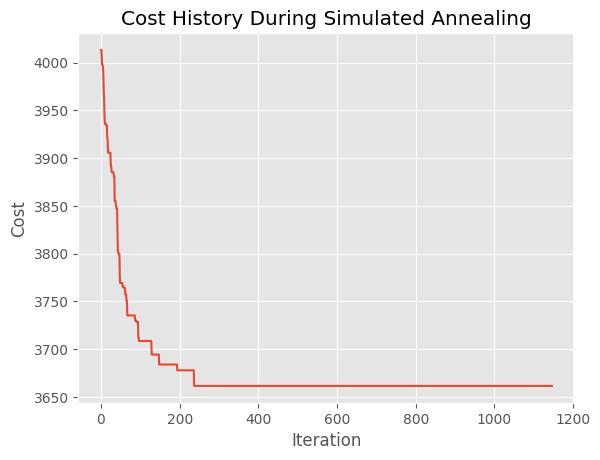

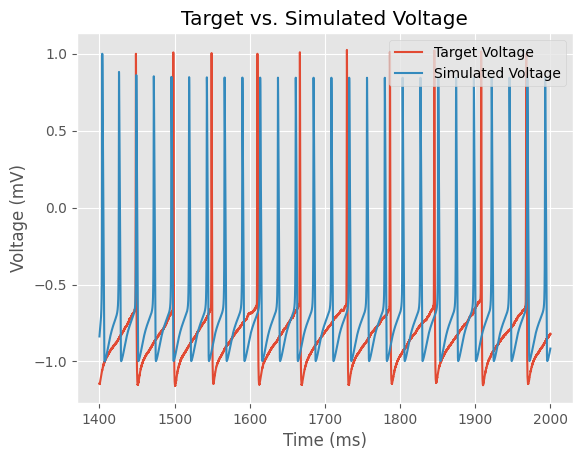

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Constants
C_m = 1.0  # μF/cm^2
E_Na = 50.0  # mV
E_K = -77.0  # mV
E_L = -54.387  # mV

# Functions for alpha and beta
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# Hodgkin-Huxley model class
class HodgkinHuxleyModel:
    def __init__(self, I, g_Na, g_K, g_L, V_init=-65.84375, m_init=None, h_init=None, n_init=None):
        self.V = V_init
        self.I = I
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.m = alpha_m(V_init) / (alpha_m(V_init) + beta_m(V_init)) if m_init is None else m_init
        self.h = alpha_h(V_init) / (alpha_h(V_init) + beta_h(V_init)) if h_init is None else h_init
        self.n = alpha_n(V_init) / (alpha_n(V_init) + beta_n(V_init)) if n_init is None else n_init
        self.history = {'V': [V_init], 'm': [self.m], 'h': [self.h], 'n': [self.n], 'I': [I]}

    def update(self, dt):
        I_Na = self.g_Na * self.m**3 * self.h * (self.V - E_Na)
        I_K = self.g_K * self.n**4 * (self.V - E_K)
        I_L = self.g_L * (self.V - E_L)

        dV = (self.I - I_Na - I_K - I_L) / C_m * dt
        self.V += dV

        dm = (alpha_m(self.V) * (1 - self.m) - beta_m(self.V) * self.m) * dt
        dh = (alpha_h(self.V) * (1 - self.h) - beta_h(self.V) * self.h) * dt
        dn = (alpha_n(self.V) * (1 - self.n) - beta_n(self.V) * self.n) * dt

        self.m += dm
        self.h += dh
        self.n += dn

        self.history['V'].append(self.V)
        self.history['m'].append(self.m)
        self.history['h'].append(self.h)
        self.history['n'].append(self.n)
        self.history['I'].append(self.I)

    def simulate(self, total_time, dt):
        steps = int(total_time / dt)
        for _ in range(steps):
            self.update(dt)
        return self.history

# Cost function for Hodgkin-Huxley model
def cost_function_hh(I, g_Na, g_K, g_L, real_v, real_t, dt):
    model = HodgkinHuxleyModel(I, g_Na, g_K, g_L)
    total_time = real_t[-1] - real_t[0]
    model.simulate(total_time, dt)
    time_points = np.linspace(real_t[0], real_t[-1], len(model.history['V']))
    sim_interp = interp1d(time_points, model.history['V'], kind='linear', fill_value='extrapolate')
    simulated_at_observed = sim_interp(real_t)
    mse = np.mean((simulated_at_observed - real_v) ** 2)
    return mse

# Simulated annealing for Hodgkin-Huxley model
def simulated_annealing_hh(I, real_v, real_t, dt):
    g_Na, g_K, g_L = 120.0, 36.0, 0.3
    best_g_Na, best_g_K, best_g_L = g_Na, g_K, g_L
    best_cost = cost_function_hh(I, g_Na, g_K, g_L, real_v, real_t, dt)
    cost_history = [best_cost]
    temp = 1.0
    temp_min = 0.00001
    alpha = 0.99

    while temp > temp_min:
        g_Na_try = g_Na + np.random.uniform(-1.0, 1.0)
        g_K_try = g_K + np.random.uniform(-1.0, 1.0)
        g_L_try = g_L + np.random.uniform(-0.01, 0.01)
        cost_try = cost_function_hh(I, g_Na_try, g_K_try, g_L_try, real_v, real_t, dt)

        if cost_try < best_cost:
            best_cost = cost_try
            best_g_Na, best_g_K, best_g_L = g_Na_try, g_K_try, g_L_try

        if cost_try < best_cost or np.random.uniform() < np.exp((best_cost - cost_try) / temp):
            g_Na, g_K, g_L = g_Na_try, g_K_try, g_L_try

        cost_history.append(best_cost)
        temp *= alpha

    return best_g_Na, best_g_K, best_g_L, cost_history

# Using the provided data v_d and t_d
I = 1.0
dt = 0.01
best_g_Na, best_g_K, best_g_L, cost_history = simulated_annealing_hh(I, v_d, t_d, dt)

print(f"Optimized Parameters: g_Na={best_g_Na}, g_K={best_g_K}, g_L={best_g_L}")

plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History During Simulated Annealing")
plt.show()

total_time = t_d[-1] - t_d[0]
steps = int(total_time / dt)
optimized_model = HodgkinHuxleyModel(I, best_g_Na, best_g_K, best_g_L)
optimized_results = optimized_model.simulate(total_time, dt)

min=np.min(optimized_results['V'])
max=np.max(optimized_results['V'])
optimized_results['V'] = 2 * (optimized_results['V'] - min) / (max - min) - 1

time = np.linspace(t_d[0], t_d[-1], len(optimized_model.history['V']))
plt.plot(t_d, v_d, label="Target Voltage")
plt.plot(time, optimized_model.history['V'], label="Simulated Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.title("Target vs. Simulated Voltage")
plt.show()

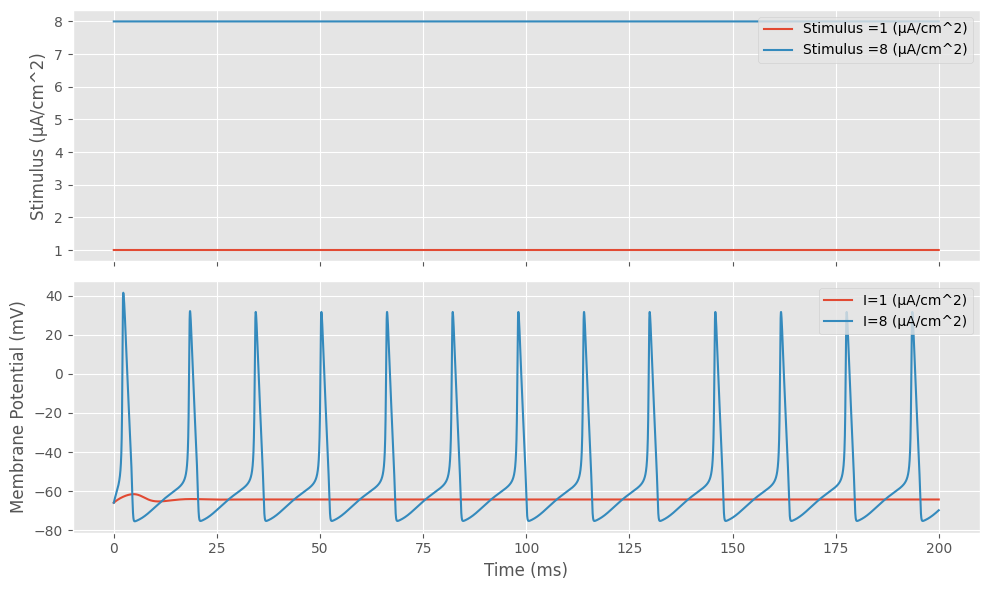

Threshold Voltage for I=6: 9.0140 mV


In [84]:
# Constants
C_m = 1.0  # μF/cm^2
E_Na = 50.0  # mV
E_K = -77.0  # mV
E_L = -54.387  # mV

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

class HodgkinHuxleyModel:
    def __init__(self, I, g_Na=120.0, g_K=36.0, g_L=0.3, V_init=-65.84375):
        self.V = V_init
        self.I = I
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.m = alpha_m(V_init) / (alpha_m(V_init) + beta_m(V_init))
        self.h = alpha_h(V_init) / (alpha_h(V_init) + beta_h(V_init))
        self.n = alpha_n(V_init) / (alpha_n(V_init) + beta_n(V_init))
        self.history = {'V': [V_init], 'm': [self.m], 'h': [self.h], 'n': [self.n], 'I': [I]}

    def update(self, dt):
        I_Na = self.g_Na * self.m**3 * self.h * (self.V - E_Na)
        I_K = self.g_K * self.n**4 * (self.V - E_K)
        I_L = self.g_L * (self.V - E_L)

        dV = (self.I - I_Na - I_K - I_L) / C_m * dt
        self.V += dV

        dm = (alpha_m(self.V) * (1 - self.m) - beta_m(self.V) * self.m) * dt
        dh = (alpha_h(self.V) * (1 - self.h) - beta_h(self.V) * self.h) * dt
        dn = (alpha_n(self.V) * (1 - self.n) - beta_n(self.V) * self.n) * dt

        self.m += dm
        self.h += dh
        self.n += dn

        self.history['V'].append(self.V)
        self.history['m'].append(self.m)
        self.history['h'].append(self.h)
        self.history['n'].append(self.n)
        self.history['I'].append(self.I)

    def simulate(self, total_time, dt):
        steps = int(total_time / dt)
        for _ in range(steps):
            self.update(dt)
        return self.history

I_values = [1,8]
total_time = 200
dt = 0.01

# Run simulations
results = []
for I in I_values:
    model = HodgkinHuxleyModel(I)
    result = model.simulate(total_time, dt)
    results.append(result)

time = np.arange(0, total_time + dt, dt)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

for index, I in enumerate(I_values):
    axs[0].plot(time, results[index]['I'], label=f'Stimulus ={I} (μA/cm^2)')
    axs[0].set_ylabel('Stimulus (μA/cm^2)')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

for index, I in enumerate(I_values):
    axs[1].plot(time, results[index]['V'], label=f'I={I} (μA/cm^2)')
    axs[1].set_ylabel('Membrane Potential (mV)')
    axs[1].set_xlabel('Time (ms)')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)


plt.tight_layout()
plt.show()

print(f"Threshold Voltage for I=6: {threshold_potential:.4f} mV")


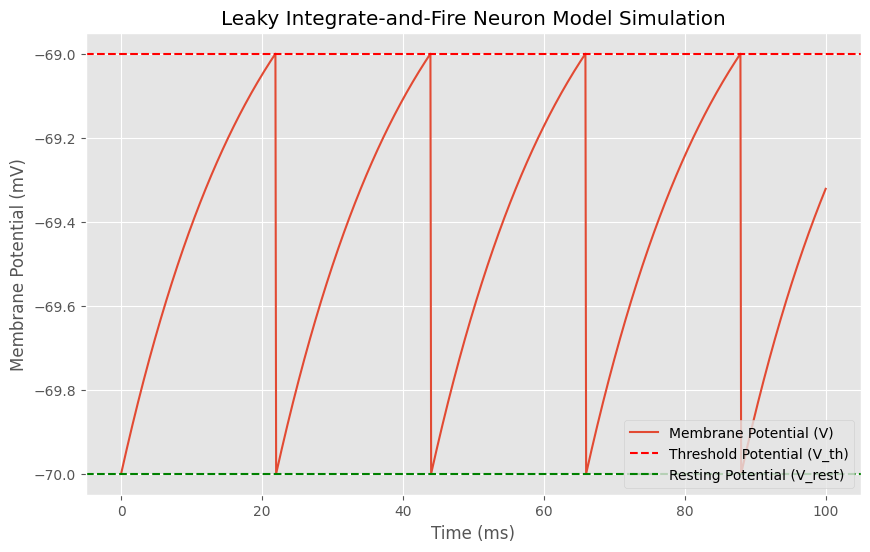

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# LIF Model
class LIFModel:
    def __init__(self, I, tau_m=20, R=1, V_rest=-70, V_th=-50, V_init=-70):
        self.V = V_init
        self.V_rest = V_rest
        self.I = I
        self.tau_m = tau_m
        self.R = R
        self.V_th = V_th
        self.history = {'V': [V_init], 'I': [I]}

    def update(self, dt):
        dVdt = ((- (self.V - self.V_rest) + self.R * self.I) / self.tau_m) * dt
        self.V += dVdt
        if self.V >= self.V_th:
            self.V = self.V_rest
        self.history['V'].append(self.V)
        self.history['I'].append(self.I)

    def simulate(self, total_time, dt):
        steps = int(total_time / dt)
        for _ in range(steps):
            self.update(dt)
        return self.history

I = 1.5
tau_m = 20
R = 1
V_rest = -70
V_th = -69
V_init = V_rest
dt = 0.1
total_time = 100

lif_model = LIFModel(I, tau_m, R, V_rest, V_th, V_init)
simulation_results = lif_model.simulate(total_time, dt)

time_points = np.linspace(0, total_time, len(simulation_results['V']))
voltage = simulation_results['V']

plt.figure(figsize=(10, 6))
plt.plot(time_points, voltage, label="Membrane Potential (V)")
plt.axhline(y=V_th, color='r', linestyle='--', label="Threshold Potential (V_th)")
plt.axhline(y=V_rest, color='g', linestyle='--', label="Resting Potential (V_rest)")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Leaky Integrate-and-Fire Neuron Model Simulation")
plt.legend()
plt.grid(True)
plt.show()
